# Hotdog/Not-Hotdog Classifier Without Transfer Learning

In [1]:
import os

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, Flatten, Dropout, MaxPooling2D
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [2]:
keras.backend.clear_session()

## Create ImageDataGenerator for real-time data augmentation in Keras

In [3]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

valid_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        '/floyd/input/hotdog/train',
        target_size=(299, 299),
        batch_size=32,
        class_mode='binary')

valid_generator = valid_datagen.flow_from_directory(
        '/floyd/input/hotdog/valid',
        target_size=(299, 299),
        batch_size=32,
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        '/floyd/input/hotdog/test',
        target_size=(299, 299),
        batch_size=32,
        class_mode='binary')

Found 2700 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
Found 644 images belonging to 2 classes.


In [4]:
print(train_generator.class_indices)
print(valid_generator.class_indices)
print(test_generator.class_indices)

{'hotdog': 0, 'nothotdog': 1}
{'hotdog': 0, 'nothotdog': 1}
{'hotdog': 0, 'nothotdog': 1}


In [5]:
train_steps = train_generator.n // train_generator.batch_size
valid_steps = valid_generator.n // valid_generator.batch_size
test_steps = test_generator.n // test_generator.batch_size


In [6]:
checkpointer = ModelCheckpoint(filepath='/floyd/home/weights.hdf5', verbose=1, save_best_only=True)

## Defining and training the model

In [7]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(299, 299, 3), padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.50))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [8]:
keras.utils.print_summary(model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 299, 299, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 299, 299, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 99, 99, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 99, 99, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 99, 99, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 49, 49, 64)        0         
__________

In [9]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

In [10]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_steps,
        epochs=50,
        validation_data=valid_generator,
        validation_steps=valid_steps,
        verbose=1,
        callbacks=[checkpointer])

Epoch 1/50
84/84 [==============================] - 67s 796ms/step - loss: 0.7775 - binary_accuracy: 0.5210 - val_loss: 0.6738 - val_binary_accuracy: 0.6181

Epoch 00001: val_loss improved from inf to 0.67379, saving model to /floyd/home/weights.hdf5
Epoch 2/50
84/84 [==============================] - 67s 792ms/step - loss: 0.6622 - binary_accuracy: 0.6179 - val_loss: 0.7177 - val_binary_accuracy: 0.6250

Epoch 00002: val_loss did not improve from 0.67379
Epoch 3/50
84/84 [==============================] - 66s 785ms/step - loss: 0.6378 - binary_accuracy: 0.6442 - val_loss: 0.6342 - val_binary_accuracy: 0.6354

Epoch 00003: val_loss improved from 0.67379 to 0.63422, saving model to /floyd/home/weights.hdf5
Epoch 4/50
84/84 [==============================] - 65s 776ms/step - loss: 0.6035 - binary_accuracy: 0.6716 - val_loss: 0.6207 - val_binary_accuracy: 0.6493

Epoch 00004: val_loss improved from 0.63422 to 0.62071, saving model to /floyd/home/weights.hdf5
Epoch 5/50
84/84 [============

In [11]:
model.load_weights('/floyd/home/weights.hdf5')

## Metrics(Accuracy) and plots(training/validation accuracy and loss)

In [12]:
model.evaluate_generator(test_generator, verbose=1, steps=test_steps)

20/20 [==============================] - 3s 172ms/step


[0.5938041627407074, 0.7109375]

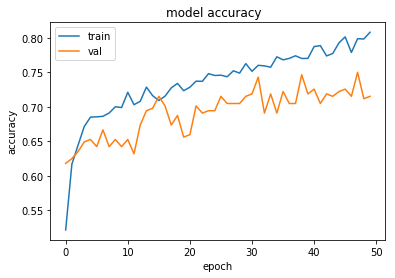

In [13]:
# summarize history for accuracy
plt.plot(history.history['binary_accuracy'] )
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy  ')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

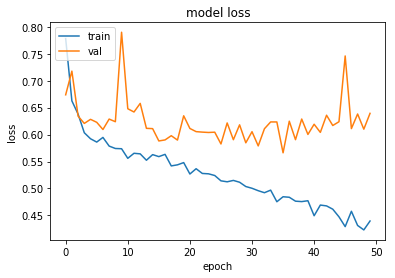

In [14]:
# summarize history for loss
plt.plot(history.history['loss'] )
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()